# Final Project Submission

- Student name: Sabina Bains
- Student pace: Self Paced
- Scheduled project review date / time: XXX
- Instructor name: Claude Fried

# Summary

Add Summary here


data - https://www.kaggle.com/code/anayad/classifying-cyberbullying-tweets/data


# Business Understanding

# Data Understanding

#### Reading in Necessary Packages

In [1]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import plot_confusion_matrix
from nltk.util import ngrams

import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [2]:
# Split then vectorize (correct way)
# We do the train/test split before the CountVectorizer to properly simulate the real world where our future data contains words we have not seen before

#### Reading in Data

In [3]:
df = pd.read_csv('data/cyberbullying_tweets.csv')


# replacing offensive words
df.tweet_text = df.tweet_text.str.replace('ggers','nnnn')
df.tweet_text = df.tweet_text.str.replace('gger','nnnn')

#### Understanding Labels

In [4]:
# checking distribution of target values - looks like a balanced dataset
pd.DataFrame(df.cyberbullying_type.value_counts(normalize=True))

cyberbullying_type
religion                       0.167701
age                            0.167575
gender                         0.167177
ethnicity                      0.166925
not_cyberbullying              0.166590
other_cyberbullying            0.164032

In [5]:
# standardizing words to all be lowercase
def lowercase(x):
    return x.lower()

df.tweet_text = df.tweet_text.apply(lowercase)

In [6]:
# tokenizing words in df to inspect differences in cyberbullying classes
def tokenize(x):
    token_pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(token_pattern)
    return tokenizer.tokenize(x)

df['tokens'] = df.tweet_text.apply(tokenize)

In [7]:
# removing stopwords from data
stopwords_list = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in stopwords_list]

df.tokens = df.tokens.apply(remove_stopwords)

FreqDist(df.tokens.explode()).most_common(30)[22:25]

[('mkr', 2543), ('muslims', 2513), ('muslim', 2491)]

In [8]:
# Above we can see we need to stem the data (muslim vs. muslims)
stemmer = SnowballStemmer(language="english")

def stem(tweets):
    return [stemmer.stem(tweet) for tweet in tweets]

df.tokens = df.tokens.apply(stem)

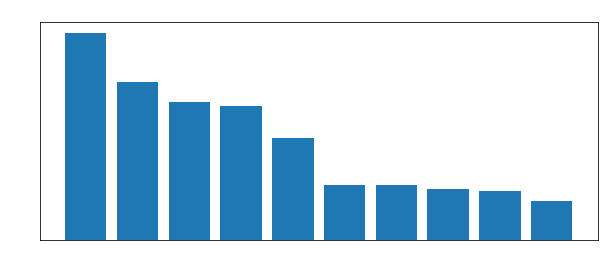

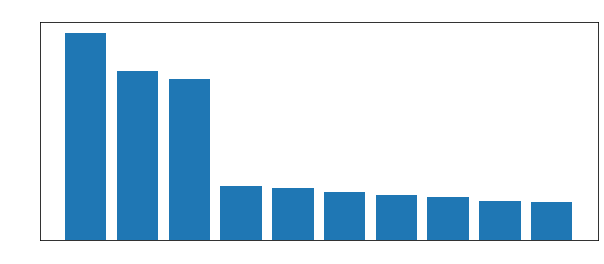

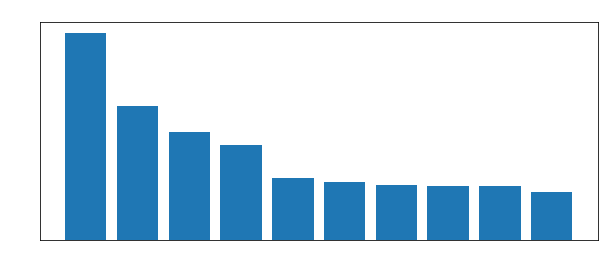

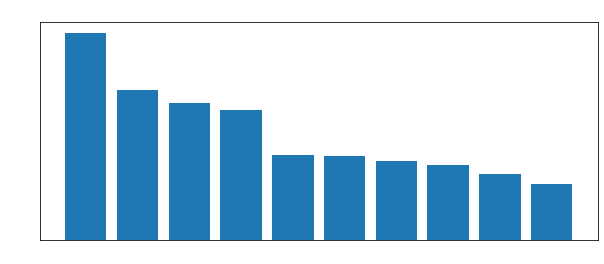

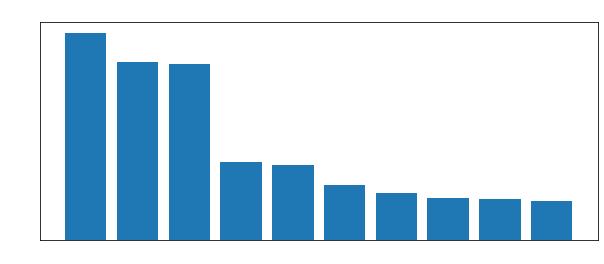

In [9]:
# Creating frequency distributions for each label to visually inspect most common words in each tag
freq_dict = {}

for target in df.cyberbullying_type.unique():
    freq_dict[target] = FreqDist(df.loc[df.cyberbullying_type == target].tokens.explode())
    
    top_10 = list(zip(*freq_dict[target].most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    fig = plt.figure(figsize=(10,4))
    plt.bar(tokens,counts)
    plt.title('Top tokens for '+target)
    plt.show()

#### Splitting Tweets and Labels into two dataframes

In [10]:
X = pd.DataFrame(df.tweet_text)
y = df.cyberbullying_type

#### Performing Train Test Split for Data Validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [69]:
# plot_confusion_matrix(baseline_model, X_train, df['cyberbullying_type']);

## creating bigrams

In [70]:
def bigram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 2)]

def _3gram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 3)]

df['bigram'] = df.tokens.apply(bigram)
df['_3gram'] = df.tokens.apply(_3gram)

In [72]:
FreqDist(df._3gram.explode()).most_common(10)

[('bulli high school', 1539),
 ('dumb ass ninnnn', 1170),
 (nan, 1127),
 ('fuck obama dumb', 979),
 ('obama dumb ass', 966),
 ('tayyoung_ fuck obama', 956),
 ('girl bulli high', 824),
 ('high school bulli', 653),
 ('rt tayyoung_ fuck', 456),
 ('girl high school', 415)]

In [15]:
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.model_selection import train_test_split, GridSearchCV
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB())])
# tuned_parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2'),
#     'clf__alpha': [1, 1e-1, 1e-2]
# }

# MODELING

In [104]:
# creating a function to evaluate models

def evaluate_multinomialnb(tfidf, model, X_train, X_test):
    X_train = tfidf.fit_transform(X_train.tweet_text)
    X_test = tfidf.transform(X_test.tweet_text)
    
    # Running next model
    train_acc = cross_val_score(model_3, X_train_v3, y_train).mean()
    test_acc = cross_val_score(model_3, X_test_v3, y_test).mean()

    print('Training Accuracy: {:.1%}'.format(train_acc))
    print('Testing Accuracy: {:.1%}'.format(test_acc))

#### Baseline Model

In [77]:
# initializing basic TFIDF vectorizer with 50 words with highest tfidf values
tfidf = TfidfVectorizer(max_features=50)

# Vectorizing tweets for modeling
X_train_v = tfidf.fit_transform(X_train.tweet_text)
X_test_v = tfidf.transform(X_test.tweet_text)

# viewing features
pd.DataFrame.sparse.from_spmatrix(X_train_v, columns=tfidf.get_feature_names()).head(1)

about  all       and       are   as   at   be  bullied  bully  but  ...  \
0    0.0  0.0  0.205042  0.137278  0.0  0.0  0.0      0.0    0.0  0.0  ...   

   they  this        to       was   we  what  who  with       you      your  
0   0.0   0.0  0.297075  0.156539  0.0   0.0  0.0   0.0  0.109612  0.853847  

[1 rows x 50 columns]

In [78]:
# Instantiating a MultinomialNB classifier
model_1 = MultinomialNB()

# Running baseline model
score_train_1 = cross_val_score(model_1, X_train_v, y_train).mean()
score_test_1 = cross_val_score(model_1, X_test_v, y_test).mean()

print('Training Accuracy: {:.1%}'.format(score_train_1))
print('Testing Accuracy: {:.1%}'.format(score_test_1))
print('''\nOur baseline model performs relatively well, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model has an
accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by removing stopwords.''')

Training Accuracy: 56.5%
Testing Accuracy: 55.7%

Our baseline model performs relatively well, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model has an
accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by removing stopwords.


#### Model #2 - removing stopwords

In [79]:
stopwords_list = stopwords.words('english')

In [82]:
# Instantiate the vectorizer
tfidf_2 = TfidfVectorizer(
    max_features=50,
    stop_words=stopwords_list
)

# Fit and transform X_train
X_train_v2 = tfidf_2.fit_transform(X_train.tweet_text)
X_test_v2 = tfidf_2.fit_transform(X_test.tweet_text)

# look at data
pd.DataFrame.sparse.from_spmatrix(X_train_v2, columns=tfidf.get_feature_names()).head(1)

about  all  and  are   as   at   be  bullied  bully  but  ...  they  this  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0    0.0  1.0  ...   0.0   0.0   

    to  was   we  what  who  with  you  your  
0  0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  

[1 rows x 50 columns]

In [83]:
# Instantiate a MultinomialNB classifier
model_2 = MultinomialNB()

# Running next model
score_train_2 = cross_val_score(model_2, X_train_v2, y_train).mean()
score_test_2 = cross_val_score(model_2, X_test_v2, y_test).mean()

print('Training Accuracy: {:.1%}'.format(score_train_2))
print('Testing Accuracy: {:.1%}'.format(score_test_2))

Training Accuracy: 64.4%
Testing Accuracy: 64.1%


#### Model #3 - Removed Stopwords and Stemmed

In [90]:
# Instantiate the vectorizer
tfidf_3 = TfidfVectorizer(
    max_features = 50,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b" #Changing tokens to include single letter words since people on twitter type in shorthand
)

# Fit the vectorizer on col and transform it
X_train_v3 = tfidf_3.fit_transform(X_train.tweet_text)
X_test_v3 = tfidf_3.transform(X_test.tweet_text)

In [91]:
# Instantiate a MultinomialNB classifier
model_3 = MultinomialNB()

# Running next model
score_train_3 = cross_val_score(model_3, X_train_v3, y_train).mean()
score_test_3 = cross_val_score(model_3, X_test_v3, y_test).mean()

print('Training Accuracy: {:.1%}'.format(score_train_3))
print('Testing Accuracy: {:.1%}'.format(score_test_3))

Training Accuracy: 65.2%
Testing Accuracy: 65.3%


#### Model #4 - Removed Stopwords and added Bigrams

In [106]:
# Instantiate the vectorizer
tfidf_4 = TfidfVectorizer(
    max_features = 80,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b",
    ngram_range = (1, 2)
)

# Instantiate a MultinomialNB classifier
model_4 = MultinomialNB()

evaluate_multinomialnb(tfidf_4, model_4, X_train, X_test)

#### NEW MODEL - adding has_link feature and is_reply

In [25]:
# creating a column that notes if a tweet has a link or not
def has_link(x):
    if 'https' in x:
        return 1
    else:
        return 0

X_train['has_link'] = X_train.tweet_text.apply(has_link)

In [26]:
# creating a column that notes if a tweet is a reply or not
def is_reply(x):
    if '@' in x:
        return 1    
    else:
        return 0

X_train['is_reply'] = df.tweet_text.apply(is_reply)

In [27]:
# resetting indices
X_train.reset_index(inplace=True)

In [28]:
# creating a column that notes if a tweet has an emoticon or not
emoticon_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'
X_train["has_emoticon"] = X_train.tweet_text.str.contains(emoticon_query)

In [29]:
# adding new columns to dataframe

X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_v, columns=tfidf.get_feature_names())
X_train_2 = pd.concat([X_train_df, X_train[['has_link', 'is_reply', 'has_emoticon']]], axis=1)
X_train_2.head(1)

also  amp  anything  ass  ass ninnnn  bitch  black  bullied  bullied high  \
0   0.0  0.0       0.0  0.0         0.0    0.0    0.0      0.0           0.0   

   bullies  ...   us  want  way  white  woman  women  would  has_link  \
0      0.0  ...  0.0   0.0  0.0    0.0    0.0    0.0    0.0         0   

   is_reply  has_emoticon  
0         0         False  

[1 rows x 83 columns]

In [30]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_score = cross_val_score(baseline_model, X_train_2, y_train).mean()
print('Accuracy: {:.1%}'.format(baseline_score))

Accuracy: 72.6%


In [ ]:
# https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8eb

### Trying Recurrent Neural Networks

bigrams and trigrams greatly improved the model's ability to classify cyberbulling. To avoid loss of knowledge while using the bag-of-words technique in multinomial bayes above, let's try using Recurrent Neural Networks. 

In [41]:
#### TRYING TENSORFLOW AND KERAS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [51]:
data = X_train.tweet_text.apply(tokenize)
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 

In [53]:
# use one hot encoding since our target is categorical
y_train_d = pd.get_dummies(y_train).values

# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones

tokenizer.fit_on_texts(list(X_train.tweet_text))
tokenized_texts = tokenizer.texts_to_sequences(X_train.tweet_text)
X_train_pad = sequence.pad_sequences(tokenized_texts, maxlen=100)

X_train_pad = pad_sequences(X_train_pad, maxlen=140)

In [64]:
# cTESTTTTTING ON. OTHER SHIT TO SEE WHAT IT DOES
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='softmax'))  # use 4 because we have 4 categories

In [55]:
# create my NN model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5)) # can work without this layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # use 4 because we have 4 categories

In [65]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape=

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         6482176   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 25)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 306       
Total params: 6,501,732
Trainable params: 6,501,732
Non-trainable params: 0
____________________________________________

In [66]:
model.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 81s 80ms/step - loss: 0.5822 - accuracy: 0.7639 - val_loss: 0.4025 - val_accuracy: 0.8429
Epoch 2/5
1006/1006 [==============================] - 84s 84ms/step - loss: 0.3143 - accuracy: 0.8746 - val_loss: 0.3936 - val_accuracy: 0.8409
Epoch 3/5
1006/1006 [==============================] - 343s 341ms/step - loss: 0.2217 - accuracy: 0.9135 - val_loss: 0.4505 - val_accuracy: 0.8292
Epoch 4/5
1006/1006 [==============================] - 96s 95ms/step - loss: 0.1720 - accuracy: 0.9303 - val_loss: 0.5016 - val_accuracy: 0.8323
Epoch 5/5
1006/1006 [==============================] - 92s 91ms/step - loss: 0.1385 - accuracy: 0.9407 - val_loss: 0.5907 - val_accuracy: 0.8253


## Links

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

data - https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

looking at diff models - https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

